# Red Inicial


## Imports


In [1]:
from __future__ import annotations

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Acciones
from custom_env.router_env import RouterEnv
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

Cargado a las 2025-03-24 16:41:09.518577


In [2]:
name = "./models/Example"
logs_path = "./logs/train/"
models_path = "./models/"
env_id = "RouterEnv-v0"

progress_bar = True
if progress_bar == True:
    import rich
    import tqdm

## Clases y Funciones


In [3]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun

def calcular_stats_acciones(acciones):
    if isinstance(acciones[-1], int):
        acciones = [Acciones.int_to_action(a) for a in acciones]
    print(f"{Acciones.DENEGAR.name}: {acciones.count(Acciones.DENEGAR)/len(acciones):.2%}")
    print(f"{Acciones.PERMITIR.name}: {acciones.count(Acciones.PERMITIR)/len(acciones):.2%}")
    

## Entrenamiento


In [ ]:
seed = None
env: RouterEnv = make(env_id, seed=seed)

check_env(env)

print("Seed: ",env._np_random_seed)

new_logger: Logger = configure(logs_path, ["stdout", "csv"])
env = Monitor(env, logs_path)


model: PPO = PPO("MultiInputPolicy", env,
                 verbose=True)


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5//0.5),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Seed:  65247122354707999425111207313807100557
Logging to ./logs/train/
Using cpu device
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -930     |
| time/              |          |
|    fps             | 199      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -511        |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004531823 |
|    clip_fraction        | 0.0139      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | -0.00151    |
|    learning_rate        | 0.0003      |
|    loss                 | 66.1        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00366    |
|    value_loss           | 8.1e+03     |
-----------------------------------------


Entrenamiento interrumpido

### Gráficas de Entrenamiento


Avaliable metrics:  ['time/iterations', 'rollout/ep_rew_mean', 'time/fps', 'time/time_elapsed', 'time/total_timesteps', 'rollout/ep_len_mean', 'train/n_updates', 'train/clip_fraction', 'train/loss', 'train/explained_variance', 'train/value_loss', 'train/approx_kl', 'train/entropy_loss', 'train/clip_range', 'train/learning_rate', 'train/policy_gradient_loss']


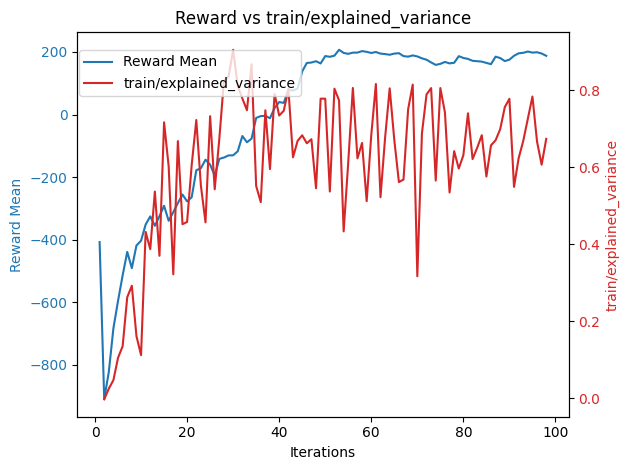

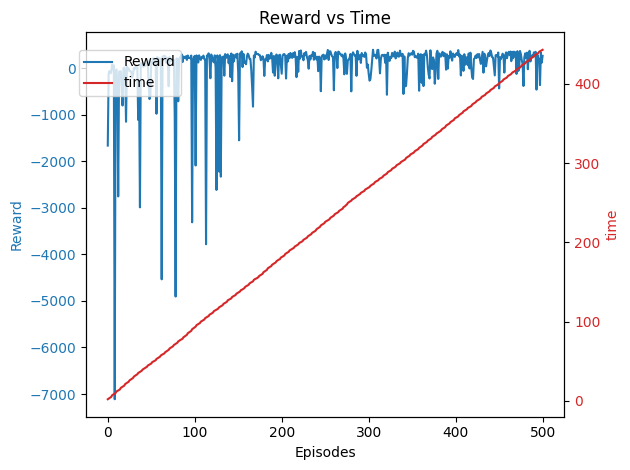

In [9]:
train_data_log: DataFrame = pd.read_csv(logs_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(logs_path+"monitor.csv", header=1)


print("Avaliable metrics: ",train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = 'tab:blue'
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))


ax1.set_xlabel('Episodes')
color = 'tab:blue'
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [10]:
seed = 289980628190634006122751570777790489191
env = make(env_id, seed=seed)
seed: int=env.np_random_seed
model = PPO.load(name, print_system_info=True)

num_steps = 1
obs, _ = env.reset(seed=seed)
# Variables de información:

stats=[]
rewards=[]

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        
        stats.append(info["Stats"])
        rewards.append(reward)

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1

# Debug
acciones=[x["Action"] for x in stats]
calcular_stats_acciones(acciones)

print(f"Seed: {env.np_random_seed}")

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

DENEGAR: 7.25%
PERMITIR: 92.75%
Seed: 289980628190634006122751570777790489191


In [11]:
assert len(acciones) != acciones.count(
    Acciones.DENEGAR), "Se han denegado todos los paquetes"
assert len(acciones) != acciones.count(
    Acciones.PERMITIR), "Se han permitido todos los paquetes"

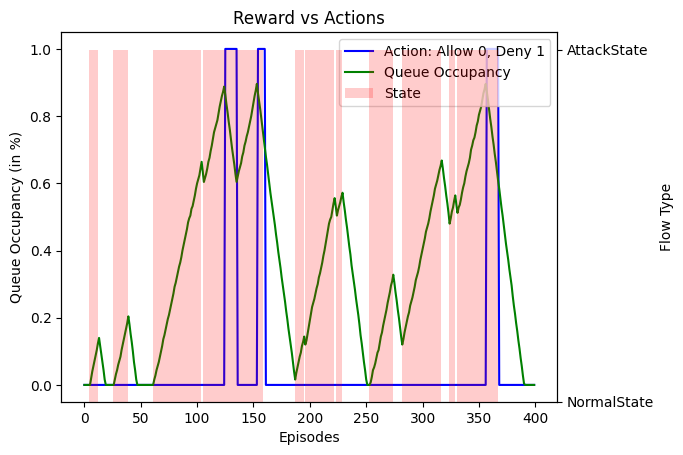

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.75, -2.75, -2.5, -2.5, -2.75, -2.75, -2.75, -2.75, -2.75, -2.5, -2.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.75, -2.5, -2.75, -2.5, -2.75, -2.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [7]:
assert len(acciones) == len(rewards)
# plt.plot(rewards, label="rewards")

fig, ax1 = plt.subplots()
ocu=[x["OcupacionActual"] for x in stats]
estados=[x["EstadoMaquina"] for x in stats]
acciones=[Acciones.action_to_int(x["Action"]) for x in stats]

# Primer eje Y con acciones y ocupación de cola
ax1.plot(acciones, label=f"Action: Allow {Acciones.action_to_int(Acciones.PERMITIR)}, Deny {Acciones.action_to_int(Acciones.DENEGAR)}",color='#0000FF')
ax1.plot(ocu, label="Queue Occupancy",color='green')
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Queue Occupancy (in %)")
ax1.set_title("Reward vs Actions")

# Segundo eje Y con estados en gráfico de barras
ax2 = ax1.twinx()
ax2.bar(range(len(estados)), estados, color='red', label="State", alpha=0.20, width=1)
ax2.set_ylabel("Flow Type")

# Combinar leyendas de ambos ejes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.show()


print("Rewards: ", rewards)
calcular_stats_acciones(acciones)

Ocupación:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.04, 0.056, 0.072, 0.088, 0.104, 0.124, 0.14, 0.116, 0.092, 0.068, 0.044, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.032, 0.044, 0.06, 0.072, 0.084, 0.104, 0.12, 0.136, 0.152, 0.168, 0.184, 0.204, 0.18, 0.152, 0.128, 0.1, 0.068, 0.044, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.028, 0.044, 0.056, 0.068, 0.084, 0.1, 0.116, 0.136, 0.148, 0.164, 0.18, 0.196, 0.208, 0.224, 0.24, 0.256, 0.272, 0.292, 0.304, 0.32, 0.336, 0.352, 0.364, 0.38, 0.4, 0.416, 0.432, 0.448, 0.464, 0.484, 0.496, 0.504, 0.524, 0.532, 0.548, 0.564, 0.584, 0.6, 0.612, 0.624, 0.644, 0.664, 0.636, 0.604, 0.616, 0.628, 0.644, 0.664, 0.676, 0.696, 0.712, 0.732, 0.752, 0.764, 0.776, 0.788, 0.808, 0.828, 0.844, 0.86, 0.872, 0.888, 0.864, 0.836, 0.812, 0.784, 0.76, 0.732, 0.704, 0.68, 0.656, 0.628, 0.604, 0.62, 0.636, 0.648, 0.66, 0.68, 0.692, 0.712, 0.724, 0.74, 0.752, 0.768, 0.784, 0.8, 0.82, 0.84, 0.86, 0.876, 0.89

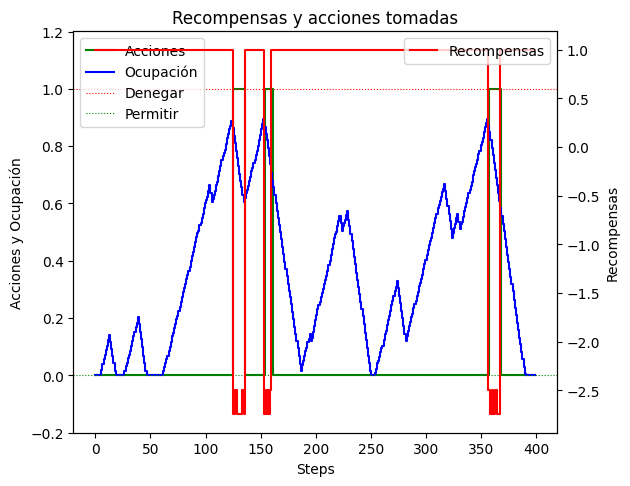

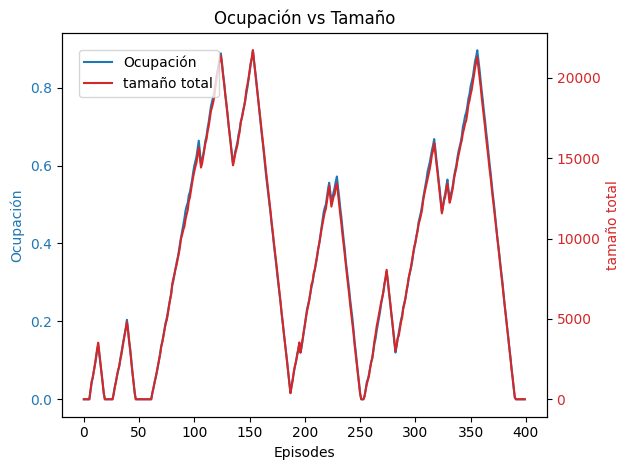

La ocupación máxima es de 90%
La ocupación mínima es de 0%


In [8]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post',color='green')
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid', color='blue')


# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales

ax1.set_yticks(sorted(ticks))  # Actualizar los ticks


ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x["TamañoTotal"] for x in stats]


fig, ax1 = plt.subplots()

train_data_monitor: DataFrame = pd.read_csv(logs_path+"monitor.csv", header=1)

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = 'tab:red'
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tam)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")